<h1>Import Libraries<h1>

<h1> Titel: Machine Learning Projekt im Bereich Direct Mail Marketing <h1>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<h1>Datensatz einlesen<h1>

In [17]:
path = r'./out/df_clean.csv'
df = pd.read_csv(path, sep=';', decimal=',')

<h1>Erläuterung der Datenspalten und Betrachtung einzelner Features<h1>

*   ZIP_CODE -> *Postleitzahl*
*   DAYS_SINCE_PURCHASE -> *Tage seit Kaufdatum*
*   PURCHASE_VISITS -> *Anzahl der Kaufbesuche*
*   TOTAL_NET_SALES -> *Gesamtnettoumsatz*
*   CC_CARD -> *Kreditkartenbenutzung*
*   AVE_AMOUNT_SPENT -> *Durchschnittlicher Betrag, der pro Besuch ausgegeben wird*
*   AMSPEND -> *im Franchise AM ausgegebener Betrag*
*   PSSPEND -> *im Franchise PS ausgegebener Betrag*
*   CCSPEND -> *im Franchise CC ausgegebener Betrag*
*   AXSPEND -> *im Franchise AX ausgegebener Betrag*
*   OMONSPEND -> *im letzten Monat ausgegebener Betrag*
*   TMONSPEND -> *in den letzten drei Monaten ausgegebener Betrag*
*   SMONSPEND -> *in den letzten sechs Monaten ausgegebener Betrag*
*   PREVPD -> *im gleichen Zeitraum des letzten Jahres ausgegebener Betrag*
*   GMP -> *Prozentsatz der Bruttomarge*
*   PROMOS -> *Anzahl der gespeicherten Marketingaktionen*
*   DAYS -> *Anzahl der Tage, in denen der Kunde registriert war*
*   FREDAYS -> *Anzahl der Tage zwischen den Käufen*
*   MARKDOWN -> *Abschlagsprozentsatz auf Kundenkäufe*
*   CLASSES -> *Anzahl der gekauften unterschiedlichen Produktklassen*
*   COUPONS -> *Anzahl der vom Kunden verwendeten Coupons*
*   STYLES -> *Gesamtzahl der vom Kunden gekauften Einzalartikel*
*   STORES -> *Anzahl der Geschäfte, in denen der Kunde eingekauft hat*
*   VALPHON -> *gültige Telefonnummer hinterlegt*
*   WEB -> *WEB-Shopper*
*   MAILED -> *Anzahl der im vergangenen Jahr verschickten Werbeaktionen*
*   RESPONDED -> *Anzahl der Werbeaktion, auf die im vergangenen Jahr reagiert wurde*
*   RESPONSERATE -> *Aktionsrücklauf für das vergangene Jahr*
*   HI -> *Produkteinheitlichkeit (niedriger Wert = unterschiedlicher Ausgabemuster)*
*   LTFREDAY -> *Lebenslage durchschnittliche Zeit zwischen Besuchen*
*   CLUSTYPE -> *Clusterzugehörigkeit*
*   PERCRET -> *Prozentsatz an Rückläufern*
*   RESP -> *Reaktion auf Promo*

<h1>Funktionen<h1>

<h3>Funktion für den Train Test Validation Split<h3>

In [18]:
#nimmt Dataframe entgegen und gibt Trainings-, Test- und Validationdataframes im Verhältnins (80%,20%,5%) zurück
def split_train_test(df):
    random_state = 4711
    features = [x for x in df.columns if x!= "RESP"]
    X = df[features]
    y = df["RESP"]
    X_train, X_test_2, y_train, y_test_2 = train_test_split(X, y, test_size = 0.05, random_state=random_state)
    X_train, X_test_1, y_train, y_test_1 = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_state)
    return X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1

<h3>Funktion für die Errechnung des Gewinns/Verlustes auf Grundlage der Gewinn-/Verlustmatrix<h3>

In [19]:
#nimmt die tatsächlichen und die vorhergesagten Werte als Series entgegen und gibt den auf Grundlage der Aufgabenstellung errechneten Gewinn/Verlust zurück
def get_result_score(y_true, y_predicted):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    y_true = y_true.to_list()
    y_predicted = y_predicted.tolist()

    for i in range(len(y_predicted)):
        if y_true[i]==y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_true[i]!=y_predicted[i]:
            FP += 1
        if y_true[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_true[i]!=y_predicted[i]:
            FN += 1


    return (TP*16+FP*(-2)+TN*(0)+FN*(-16))

<h1>Random Forest Classifier<h1>

**Betrachtete Hyperparameter Random Forest**

*   n_estimators: Anzahl erstellter Entscheidungsbäume innerhalb des Random Forest 
*   max_features: Maximale Anzahl an Features, für die Erstellung eines Entscheidungsbaums
*   max_depth: Maximale Tiefe jedes Entscheidungsbaums innerhalb des Random Forest
*   bootstrap: Mit oder ohne Zurücklegen, bei der zufälligen Auswahl der subsamples

<h3>Beispiel: Erster Random Forest Classifier mit einer maximalen Tiefe von 4<h3>

Accuracy:  84.70104091019124 %
Recall:  18.207282913165265 %
Precision:  73.03370786516854 %
F1 Score:  29.14798206278027 %


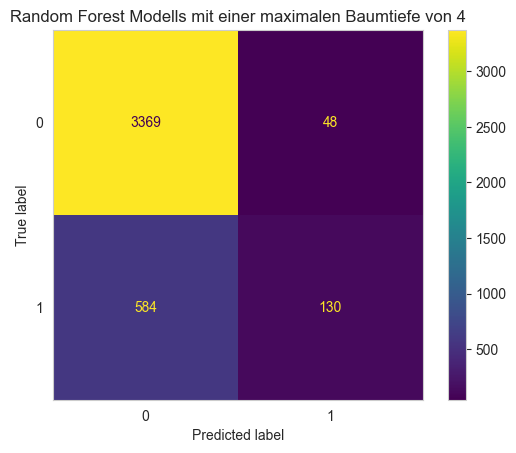

In [20]:
X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1 = split_train_test(df) #Train-,Test-,Validationsplit
rf = RandomForestClassifier(max_depth=4, random_state=4711) #Classifier Instanz erstellen
rf.fit(X_train, y_train) #Trainieren mit Train Datasplit
y_predict = rf.predict(X_test_1) #Klassifikation der Test1 Daten

accuracy = accuracy_score(y_test_1, y_predict) #Errechnung des accuracy Scores der Vorhersage: Accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = precision_score(y_test_1, y_predict) #Errechnung des precision Scores der Vorhersage: Precision = TP/(TP+FP)
recall = recall_score(y_test_1, y_predict) #Errechnung des recall Scores der Vorhersage: Recall = TP/(TP+FN)
f1score = f1_score(y_test_1, y_predict) #Errechnung des F1Scores der Vorhersage: F1Score = ((1/Precision+1/Recall)/2)^-1

print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")

## Confusion Matrix der Klassifizierung ausgeben
matrix = confusion_matrix(y_test_1,y_predict,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rf.classes_)
disp.plot()
plt.grid(False)
plt.title("Random Forest Modells mit einer maximalen Baumtiefe von 4")
plt.show()

<h3>Dabei von dem Random Forest Classifier genutzte Parameter<h3>

In [21]:
print("Parameters currently in use:\n")
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 4711,
 'verbose': 0,
 'warm_start': False}


<h4>Betrachtung der 10 Features, die bei diesem Random Forest Classifier am stärksten zur Klassifizierung beigetragen haben.<h4>

<h4>Erstellen von Arrays mit Hyperparameterwerten, die für die GridSearch genutzt werden sollen<h4>

{'bootstrap': [True, False],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


C:\Users\svenb\AppData\Local\Temp\ipykernel_8988\1559226668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important_features["RESP"] = df["RESP"]


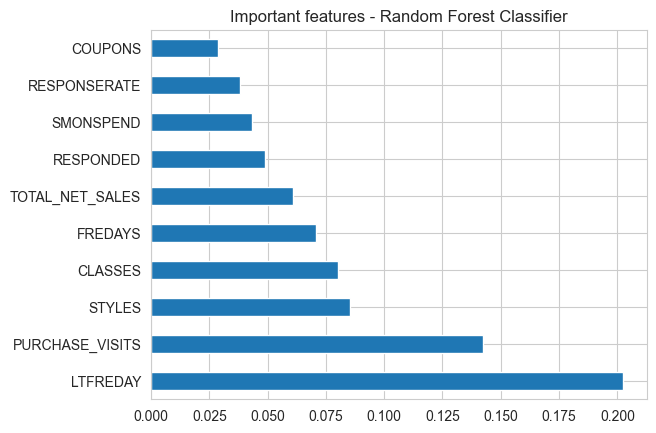

In [22]:
#Ausgabe der Top 10 Features auf Grundlage des Mean Decrease in Impurity (MDI)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns) #Erstellen einer Series mit MDI Werten und zugehörigen feature Namen
feat_importances.nlargest(10).plot(kind='barh', title = "Important features - Random Forest Classifier") #Darstellen der nach MDI Wert 10 wichtigsten Features bei der Erstellung des Random Forest Classifiers


#Erstellen von Train-,Test- und Validationsplits nur mit den 10 wichtigsten Features
important_features = feat_importances.nlargest(10).index 
df_important_features = df[important_features]
df_important_features["RESP"] = df["RESP"]
X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1 = split_train_test(df_important_features)

# Lösungsraum für die Hyperparameteroptimierung festlegen
# Anzahl erstellter Entscheidungsbäume
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
# Maximale Anzahl an Features, für die Erstellung eines Entscheidungsbaums
max_features = ["auto", "sqrt"]
# Maximale Tiefe jedes Entscheidungsbaums
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
# Mit oder ohne Zurücklegen, bei der zufälligen Auswahl der Subsamples
bootstrap = [True, False]

# Erstellen des grids
grid = {"n_estimators":n_estimators,
               "max_features":max_features,
               "max_depth":max_depth,
               "bootstrap":bootstrap}
pprint(grid)

<h2>Erneute Klassifizierung anhand eines Random Forest Classifiers, mit vorangegangener GridSearch der zuvor bestimmten Hyperparameter(werten) und Optimierung auf Grundlage der Ergebnisse der definierten individuellen Scorer Funktion<h2>

In [23]:
# Zuvor erstelltes grid für die Hyperparameteroptimierung nutzen
rf = RandomForestClassifier(random_state = 4711)

#eigene Funktion als Scorer für die GridSearch
result_scorer = make_scorer(get_result_score)       

# GirdSearch mit 3 fold cross validation, Suche über die zuvor definierten Parameter

#Suche nach optimalen Parametern unter Berücksichtigung des Gewinns/Erlöses
rf_random_result_score = GridSearchCV(estimator = rf, param_grid = grid,
                                      cv = 3, verbose = 2,
                                      n_jobs = -1, scoring = result_scorer)

#Suche nach optimalen Parametern unter Berücksichtigung der Accuracy
rf_random_result_accuracy = GridSearchCV(estimator = rf, param_grid = grid,
                                         cv = 3, verbose = 2,
                                         n_jobs = -1)

#Suche nach optimalen Parametern unter Berücksichtigung des Recalls
rf_random_result_recall = GridSearchCV(estimator = rf, param_grid = grid, 
                                       cv = 3, verbose = 2, 
                                       n_jobs = -1, scoring = "recall")

# GridSearch Instanzen mit Trainingsdaten fitten
rf_random_result_score_res = rf_random_result_score.fit(X_train, y_train)
rf_random_result_accuracy_res = rf_random_result_accuracy.fit(X_train, y_train)
rf_random_result_recall_res = rf_random_result_recall.fit(X_train, y_train)

# Ausgabe des jeweils besten Scores und der optimalen dafür genutzten Parameter
print("Bester Score nach Gewinn/Verlust mit eigener Funktion: ",rf_random_result_score_res.best_score_)
print("Mit besten Parametern: ",rf_random_result_score_res.best_params_)
print("Bester Score nach Accuracy: ",rf_random_result_accuracy_res.best_score_)
print("Mit besten Parametern: ",rf_random_result_accuracy_res.best_params_)
print("Bester Score nach Recall: ",rf_random_result_recall_res.best_score_)
print("Mit besten Parametern: ",rf_random_result_recall_res.best_params_)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Bester Score nach Gewinn/Verlust mit eigener Funktion:  -5797.333333333333
Mit besten Parametern:  {'bootstrap': False, 'max_depth': 40, 'max_features': 'auto', 'n_estimators': 200}
Bester Score nach Accuracy:  0.8558891091582699
Mit besten Parametern:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300}
Bester Score nach Recall:  0.3146314631463146
Mit besten Parametern:  {'bootstrap': False, 'max_depth': 40, 'max_features': 'auto', 'n_estimators': 200}


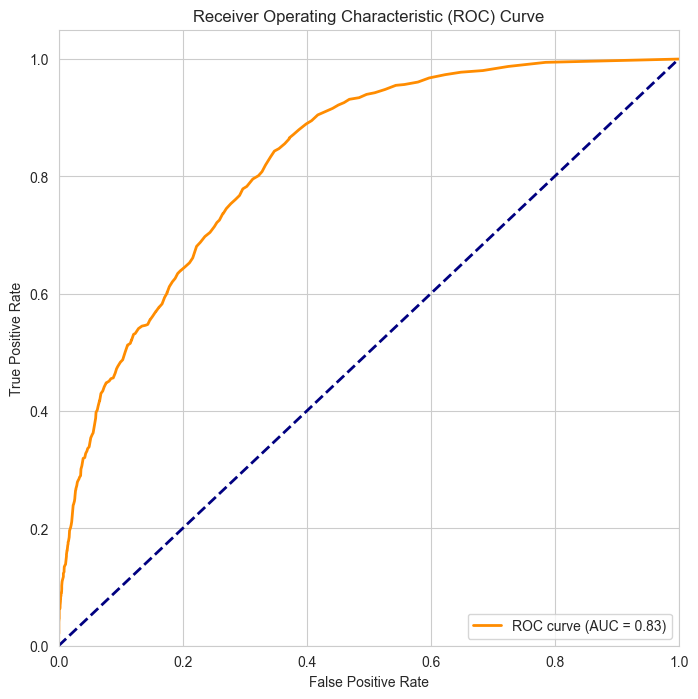

y_true:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

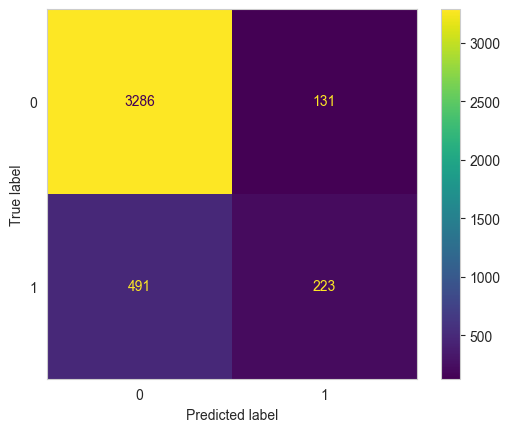

In [24]:
# Erstellen einer neuen Modellinstanz mit den zuvor ermittelten besten Hyperparametern bei Berücksichtung des Gewinns/Verlusts
rf = RandomForestClassifier(random_state=4711, max_depth=40, n_estimators=200, max_features="auto",bootstrap=False)
# Trainieren des Modells mit Trainingsdaten
rf.fit(X_train,y_train)
# Ermitteln der Wahrscheinlichkeiten die von dem Calssifier für eine Vorhersage der Klasse 1 (Kunde reagiert) ermittelt wurden
y_probabilities = rf.predict_proba(X_test_1)[:, 1]
# Klassifikation der Test1 Daten
y_predicted = rf.predict(X_test_1)

#Berechnen der ROC-Kurve und des AUC-Werts
fpr, tpr, thresholds = roc_curve(y_test_1, y_probabilities) #fpr-FalsePositiveRate, tpr-TruePositiveRate
roc_auc = auc(fpr, tpr)

#Plot der ROC-Kurve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Ermitteln der Accuracy, Precision, Recall, F1Score und Gewinn/Verlusts
accuracy = accuracy_score(y_test_1, y_predicted)
precision = precision_score(y_test_1, y_predicted)
recall = recall_score(y_test_1, y_predicted)
f1score = f1_score(y_test_1, y_predicted)
score = get_result_score(y_test_1, y_predicted)

#Ausgabe der Werte
print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Score: ", score)

#Ausgabe der zugehörigen Confusion Matrix
matrix = confusion_matrix(y_test_1,y_predicted,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rf.classes_)
disp.plot()
plt.grid(False)
plt.show()

<h2>Threshold Tuning<h2>

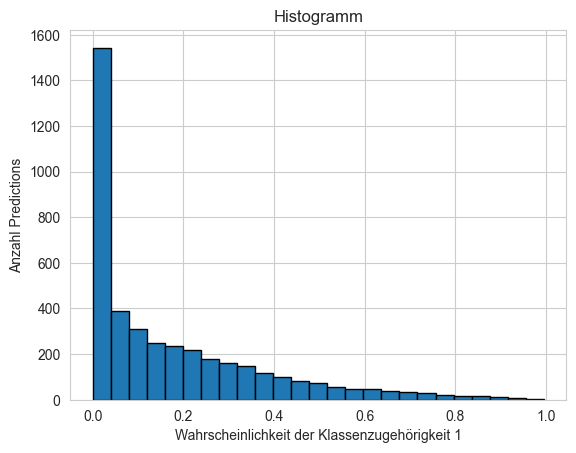

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y_true:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

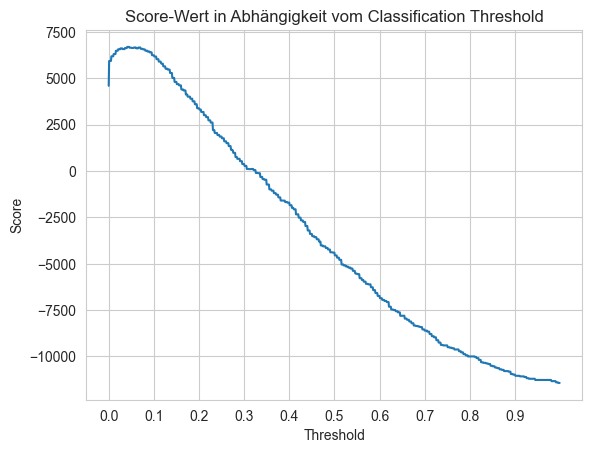

In [25]:
# Funktion die der Threshold Wert und die Wahrscheinlichkeit der Klassenzugehörigkeit 1 entgegennimmt und einen diesen zurückgibt, solange die Wahrscheinlichkeit der Klassenzugehörigkeit über dem Threshold liegt (sonst 0)
def to_labels(probabilities, threshold):
    return(probabilities >= threshold).astype("int")

# Erstellen einer neuen Modellinstanz mit den zuvor ermittelten besten Hyperparametern bei Berücksichtung des Gewinns/Verlusts
rf = RandomForestClassifier(random_state=4711, max_depth=40, n_estimators=200, max_features="auto",bootstrap=False)
# Trainieren des Modells mit Trainingsdaten
rf.fit(X_train,y_train)
# Vorhersage der Zielvariablen auf für die Test1 Daten
y_predicted = rf.predict_proba(X_test_1)
# Ermitteln der Wahrscheinlichkeiten mit denen eine Klassifiaktion der Klasse 1 (Kunde reagiert) erfolgt
probs = y_predicted[:,1]
# Darstellung der Wahrscheinlichkeiten in einem Histogramm
plt.hist(probs, bins=25, edgecolor='black')
plt.xlabel('Wahrscheinlichkeit der Klassenzugehörigkeit 1')
plt.ylabel('Anzahl Predictions')
plt.title('Histogramm')
plt.show()

# Liste mit Thresholds von 0 bis 1 in 0.001 Steps
thresholds = np.arange(0,1,0.001)
# Ermitteln der Scores unter Berücksichtigung der unterschiedlichen Thresholds
scores = [get_result_score(y_test_1,to_labels(probs,t)) for t in thresholds]
# Ermitteln des List Indexes an dem der Gewinn/Erlös am größten ist
max_threshold = np.argmax(scores)
# Ausgabe des besten Gewinns/Verlusts mit optimalen Threshold
print("Threshold= ",thresholds[max_threshold],"Score-Wert= ",scores[max_threshold])
# Darstellung des Gewinns/Verlusts unter Berücksichtigung der Thresholds
plt.plot(np.arange(0,1,0.001), scores)
plt.xticks(np.arange(0,1,0.1))
plt.title("Score-Wert in Abhängigkeit vom Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel('Score')
plt.show()

y_true:  [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 

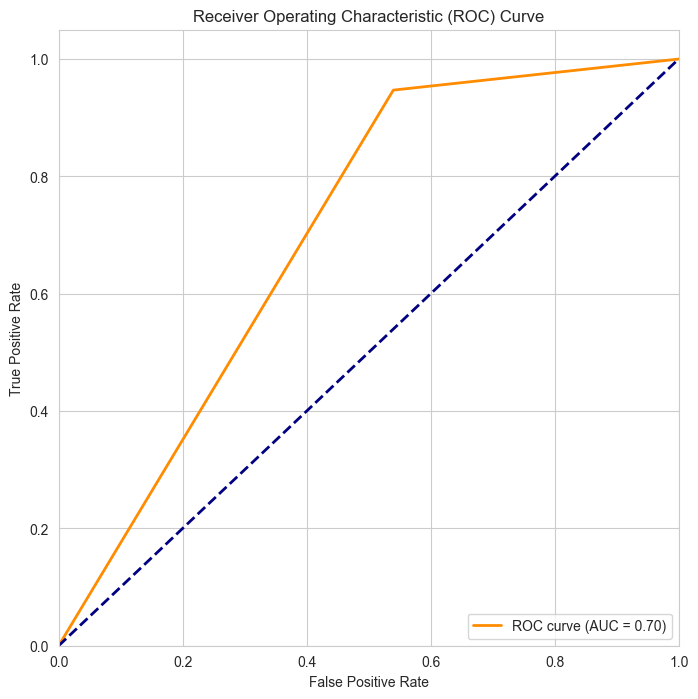

Accuracy:  53.633854645814175 %
Recall:  94.70588235294117 %
Precision:  24.54268292682927 %
F1 Score:  38.983050847457626 %
Score:  1442


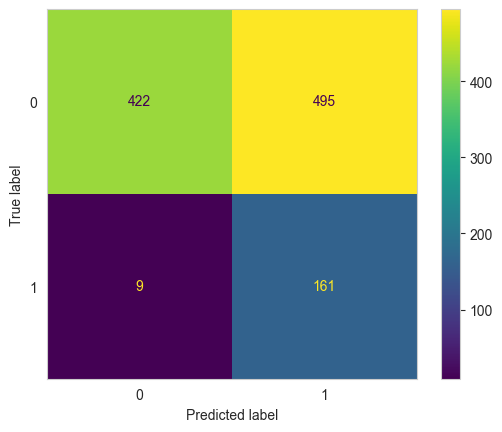

In [28]:
# Erstellen und Trainieren einer neuen Modellinstanz
rf = RandomForestClassifier(random_state=4711, max_depth=40, n_estimators=200, max_features="auto",bootstrap=False)
rf.fit(X_train,y_train)
# Vorhersage der Klasse für die finalen Test2 Daten unter Berücksichtigung eines Classification Thresholds von 8,5%
y_predicted = (rf.predict_proba(X_test_2)[:,1]>=0.041).astype(bool)
# Ermitteln der Accuracy, Precision, Recall, F1Score und Gewinn/Erlös
accuracy = accuracy_score(y_test_2, y_predicted)
precision = precision_score(y_test_2, y_predicted)
recall = recall_score(y_test_2, y_predicted)
f1score = f1_score(y_test_2, y_predicted)
score = get_result_score(y_test_2, y_predicted)

#Berechnen der ROC-Kurve und des AUC-Werts
fpr, tpr, thresholds = roc_curve(y_test_2, y_predicted)
roc_auc = auc(fpr, tpr)

#Plot der ROC-Kurve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Ausgabe der Scores
print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Score: ", score)

# Darstellung der Confusion Matrix
matrix = confusion_matrix(y_test_2,y_predicted,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rf.classes_)
disp.plot()
plt.grid(False)
plt.show()

<h2>Baseline Strategie<h2>

In [29]:
# Errechnung des Gewinn/Verlusts bei Befolgung der Baseline Strategie
len(y_test_2)
count_RESP_yes = sum(y_test_2)
count_RESP_no = len(y_test_2) - sum(y_test_2)
baseline = (count_RESP_yes*16)+(count_RESP_no*(-2))
print(baseline)

886
